# Principal Component Analysis

## Objectives

- Explain the concepts behind principal component analysis (PCA)
- Explain how PCA addresses the problem of multicollinearity
- Explain the idea of eigendecomposition
- Implement PCA using `sklearn`

# Motivation

So far, you have dealt with datasets with a moderate number of predictors. What would happen if you had thousands of predictors? 

A few problems can arise:

* Requires a ton of computing power/time
* Computational problems caused by multicollinearity
* Can overfit your data

How could we address this problem?

* You could drop a bunch of predictors at random, but you would potentially lose useful information that way 
* You could drop predictors that have weak correlations with your target, but they may still be useful in combination with other features in non-linear models (e.g. interaction terms, decision trees) 
* You could combine a bunch of features together, such as by multiplying them, but it's not clear how you would do this to best preseve information

Principal Component Analysis (PCA) is a tool for reducing the dimensionality of our data in a way that tries to preserve information. It does this by **projecting our data from a higher-dimensional space onto a lower-dimensional space**. The PCA algorithm chooses a lower-dimensional space to project to that will **preserve as much variance as possible** from our original dataset.

### Steps for Performing PCA

The theory behind PCA rests upon many foundational concepts of linear algebra. After all, PCA is re-encoding a dataset into an alternative basis (the axes). Here's the exact steps:

1. Recenter each feature of the dataset by subtracting that feature's mean from the feature vector
2. Calculate the covariance matrix for your centered dataset
3. Calculate the eigenvectors of the covariance matrix
4. Project the dataset into the new feature space: Multiply the eigenvectors by the mean centered features

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-unsupervised-learning-online-ds-pt-100719/master/images/pca.gif">

# Scenario: Shipping Costs

A bit of a contrived example to showcase what's going on under the hood - this example only has a few predictors, but we can still use PCA in this instance!

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

np.random.seed(123)

Let's say that we want to predict the cost to ship a package based on its properties. 

In [2]:
packages = pd.read_csv('data/packages.csv')
packages.head(10)

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
0,24,36,32,9,18,1079
1,38,41,31,12,18,1797
2,38,34,34,15,24,1722
3,20,32,22,8,8,461
4,24,37,24,14,19,491
5,21,32,20,3,6,1029
6,27,33,23,7,11,945
7,31,40,31,16,22,1649
8,30,37,28,12,20,1310
9,26,29,29,11,11,161


## Dimensionality

If we focus on just one input feature, we can easily visualize its relationship with our outcome variable in 2 dimensional space:

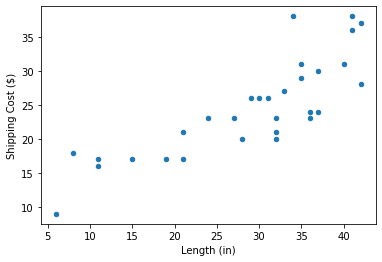

In [3]:
packages.plot(kind='scatter', y='Shipping Cost ($)', x='Length (in)');

But we have more features! You can think of each package as a point in six-dimensional space - 5 dimensions for our features and 1 for our target.

## Correlation and Covariance Matrices

The first four features in this dataset all relate to package size, so we might expect them to be strongly related.

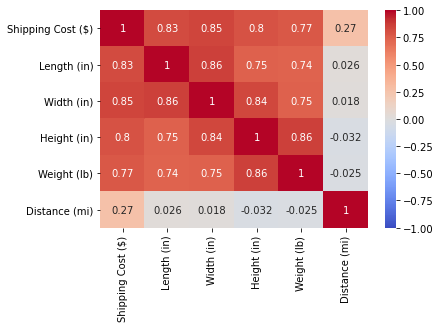

In [4]:
sns.heatmap(packages.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='coolwarm');

PCA does not use this **correlation matrix**, which is conveniently scaled between -1 and 1. Rather, it uses the **covariance matrix**, which is scaled in square units of the original variables. This makes PCA very sensitive to the scale of the variables.

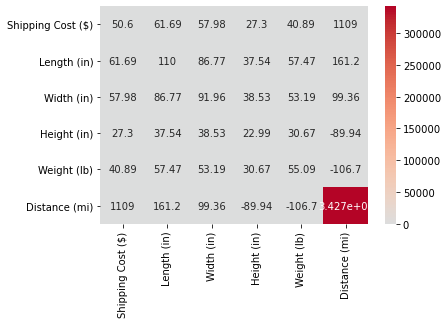

In [5]:
sns.heatmap(packages.cov(),
            annot=True,
            fmt='0.4g',
            center=0,
            cmap='coolwarm');

Let's normalize our variables to mean = 0 & SD = 1 (AKA standard scale), which will make our covariance matrix equal the correlation matrix.

In [6]:
# Instantiate and fit_transform our data
# No need for a train test split here - just exploring
scaler = StandardScaler()
packages_scaled = scaler.fit_transform(packages)

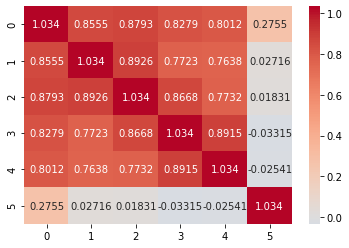

In [7]:
# Note that we need to use np.cov now, since packages_scaled is now a numpy array
sns.heatmap(np.cov(packages_scaled, rowvar=False),
            annot=True,
            fmt='0.4g',
            center=0,
            cmap='coolwarm');

BECAUSE MATH, and some properties of this kind of matrix, the covariance matrix preserves the information about the spread of our dataset. What we want to do now is to explain that spread, one linear transformation (one **eigenvector**) at a time. For more see [this useful blog post](https://datascienceplus.com/understanding-the-covariance-matrix/).

Let's try to reduce the dimensionality of our dataset. Since the features capturing size are strongly correlated, we might expect to be able to reduce our feature dimensions down to two without losing much information (i.e. variance in our features).

## Eigendecomposition

We will use an **eigendecomposition** of the covariance matrix to create a new set of dimensions. We can then decide how many of these dimensions to keep based on how much variance is captured by each dimension.

Here, we show you how to do this using the NumPy `.eig()` function, but we will learn how to do PCA more easily in `sklearn` later.

In [8]:
packages_scaled_df = pd.DataFrame(packages_scaled, columns=packages.columns)
y_packages_scaled = packages_scaled_df['Shipping Cost ($)']
X_packages_scaled = packages_scaled_df.drop('Shipping Cost ($)', axis=1)

cov_mat = X_packages_scaled.cov().values
eigvals, eigvecs = np.linalg.eig(cov_mat)

This decomposition gives us two things: eigenvalues and eigenvectors.

## Eigenvalues

**Eigenvalues** represent the relative amount of variance captured by each new dimension. The average eigenvalue will be 1, so we look for values over 1 to identify dimensions that capture more variance than average. 

In [9]:
eigvals

array([3.51539036, 1.03842995, 0.34539962, 0.08906359, 0.18413027])

It looks like we have one great dimension capturing 3.4x more variance than average, one OK dimension capturing an average amount of variance, and three other dimensions that don't capture much variance. This is in line with what we were expecting! It means that we can just use the first two dimensions - and drop the last three - without losing much variance/information from our predictors.

### Proportion of Variance

You can also divide your eigenvalues by the number of features and then interpret them as the _proportion of variance in the features_ captured by each dimension.

In [10]:
eigvals/len(eigvals)

array([0.70307807, 0.20768599, 0.06907992, 0.01781272, 0.03682605])

## Eigenvectors (aka Principal Components)

**Eigenvectors** represent the new dimensions, which we call **principal components** when doing PCA. There is one eigenvector for each dimension, and they are all combined together into one matrix.

In [11]:
eigvecs

array([[-0.49219397, -0.04575099,  0.58937372,  0.39011986,  0.50606033],
       [-0.50780159, -0.03152634,  0.38635373, -0.59429315, -0.48855918],
       [-0.5075545 ,  0.03825687, -0.38501594,  0.58895092, -0.49580679],
       [-0.49220305,  0.03337828, -0.59133959, -0.38424744,  0.50920864],
       [ 0.00268878, -0.9971636 , -0.07382155,  0.01062355, -0.00974944]])

In PCA, the values in our eigenvectors are called **component weights**, and they tell us how much variance of each feature is captured by that dimension. These weights range from -1 to 1, but the relative sizes are what matter.

### Orthogonality

These eigenvectors are **orthogonal**, meaning their dot product is zero. Think of it like being at right angles, like the x and y axes of a graph, but in higher-dimensional space. 

NICE TOUCH: orthogonal vectors are not multicollinear! Always! 

In [12]:
eigvec1 = eigvecs[:, 0]
eigvec2 = eigvecs[:, 1]
eigvec1.dot(eigvec2)

5.551115123125783e-17

### First Principal Component

The first column of `eigvecs` is our first eigenvector, corresponding to the eigenvalue of 3.4. Let's look at it.

In [13]:
dict(zip(X_packages_scaled.columns, eigvec1))

{'Length (in)': -0.49219397024747946,
 'Width (in)': -0.5078015906341329,
 'Height (in)': -0.5075545014020556,
 'Weight (lb)': -0.4922030462881768,
 'Distance (mi)': 0.0026887790198376676}

Notice that the first four numbers are relatively large, while the fifth is near zero. This means that this first dimension is almost entirely capturing the shared variance in our four size features, as we hoped! It's also interesting to note that the weights for the four features are almost equal, so they are equally represented in this dimension.

### Second Principal Component

Let's look at our second eigenvector and see what features it seems to be capturing.

In [14]:
dict(zip(X_packages_scaled.columns, eigvec2))

{'Length (in)': -0.04575099446953344,
 'Width (in)': -0.031526343225015366,
 'Height (in)': 0.03825686657391803,
 'Weight (lb)': 0.03337828478319772,
 'Distance (mi)': -0.9971635966343659}

Looks like it is almost entirely capturing the distance dimension, which makes sense, since that is not related to the package size at all. It has an eigenvalue of 1, which is appropriate, since the eigenvector only captures one feature, which wasn't captured at all in the first principal component.

## Transforming Data

We will now use these principal components to create new features. These features will be weighted sums (aka **linear combinations**) of existing features, using the component weights from the eigenvectors.

### First Component

We will now create a new feature using the first principal component. 

In [15]:
dict(zip(X_packages_scaled.columns, eigvec1))

{'Length (in)': -0.49219397024747946,
 'Width (in)': -0.5078015906341329,
 'Height (in)': -0.5075545014020556,
 'Weight (lb)': -0.4922030462881768,
 'Distance (mi)': 0.0026887790198376676}

Our first feature will be calculated as follows:

**PC1** = 0.492 * Length + 0.508 * Width + 0.508 * Height + 0.492 * Weight - 0.003 * Distance

We use a dot product between the data and the eigenvector to do the arithmetic for us.

In [16]:
data_array = X_packages_scaled.values
pc1 = data_array.dot(eigvec1)
X_packages_pca = pd.DataFrame(data=pc1, columns=['PC1'])
X_packages_pca.head()

,PC1
0,-1.212899
1,-1.717358
2,-2.272847
3,0.295933
4,-1.438280


### All Components

You can calculate all the new features at once using a dot product with the `eigvecs` matrix, which has all the eigenvectors in it.

In [17]:
pcs = data_array.dot(eigvecs)
X_packages_pca = pd.DataFrame(data=pcs, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_packages_pca.head(10)

,PC1,PC2,PC3,PC4,PC5
0,-1.212899,0.011849,0.414848,-0.598483,0.166703
1,-1.717358,-1.226548,0.322565,0.041777,0.136238
2,-2.272847,-1.023795,-0.676236,-0.354703,-0.258341
3,0.295933,1.079836,0.747722,0.270744,-0.093598
4,-1.438280,1.097996,-0.269804,0.504775,0.184208
5,1.079538,0.052765,1.163349,-0.112051,0.386725
6,0.101911,0.239155,0.622347,-0.028424,0.209983
7,-2.370782,-0.914950,-0.366448,0.290311,-0.051904
8,-1.502014,-0.345915,-0.128624,-0.034766,0.243188
9,-0.464635,1.627544,0.413444,-0.072711,-0.704668


## Feature Correlations

I told y'all earlier that each of these components were naturally not correlated - let's prove it!

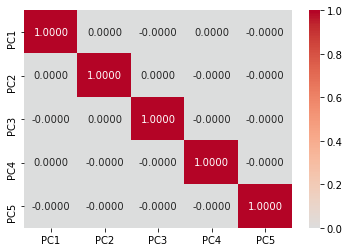

In [18]:
sns.heatmap(X_packages_pca.corr(),
            annot=True,
            fmt='0.4f',
            center=0,
            cmap= 'coolwarm');

## Check Performance

One of the benefits of using principal component analysis is that using just a few components can perform just as well as using many original columns - reducing complexity and multicollinearity in your models. 

In [19]:
# Linear regression using the original features
lr_orig = LinearRegression()

lr_orig.fit(X_packages_scaled, y_packages_scaled)

lr_orig.score(X_packages_scaled, y_packages_scaled)

0.8551465133243149

In [20]:
# Linear regression using just the first two principal components
lr_pca = LinearRegression()

lr_pca.fit(X_packages_pca[['PC1', 'PC2']], y_packages_scaled)

lr_pca.score(X_packages_pca[['PC1', 'PC2']], y_packages_scaled)

0.8520244462637743

#### Discuss:

- 


# ACTIVITY: USING PCA TO COLLAPSE 1800+ HEALTH FEATURES TO 10


- Use all 1100+ features of the [National Health and Nutrition Examination Survey (NHANES)](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey) to find clusters of people in 3D space.
- Build a Pipeline for data processing.
- Get top 10 principal components.
- Visualize 3 principal components at a time in 3D.


## Data
- [NHANES Dataset](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey)
    
- [Complete variable list](https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Demographics&CycleBeginYear=2013)

In [29]:
# more imports
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import os, sys
import glob

In [30]:
# Study Group Notebook Folderpath
folder = 'data/NHANES/'
os.listdir(folder)

['demographic.csv',
 'diet.csv',
 'examination.csv',
 'labs.csv',
 'medications.csv',
 'questionnaire.csv']

In [31]:
## Use glob to get list of csvs
files = glob.glob(folder+'*.csv')
files

['data/NHANES\\demographic.csv',
 'data/NHANES\\diet.csv',
 'data/NHANES\\examination.csv',
 'data/NHANES\\labs.csv',
 'data/NHANES\\medications.csv',
 'data/NHANES\\questionnaire.csv']

In [48]:
## Load in all CSVs combined 
df = pd.concat([pd.read_csv(file, index_col='SEQN', engine= 'python') for file in files[1:]],axis=1)
df.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,16888.327864,12930.890649,1.0,49.0,2.0,2.0,6.0,2.0,1.0,1.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
73557,16888.327864,12930.890649,1.0,49.0,2.0,2.0,6.0,2.0,1.0,1.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
73558,17932.143865,12684.148869,1.0,59.0,2.0,2.0,4.0,1.0,1.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
73558,17932.143865,12684.148869,1.0,59.0,2.0,2.0,4.0,1.0,1.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
73558,17932.143865,12684.148869,1.0,59.0,2.0,2.0,4.0,1.0,1.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN


In [56]:
encoding_list = ['ascii', 'big5', 'big5hkscs', 'cp037', 'cp273', 'cp424', 'cp437', 'cp500', 'cp720', 'cp737'
                 , 'cp775', 'cp850', 'cp852', 'cp855', 'cp856', 'cp857', 'cp858', 'cp860', 'cp861', 'cp862'
                 , 'cp863', 'cp864', 'cp865', 'cp866', 'cp869', 'cp874', 'cp875', 'cp932', 'cp949', 'cp950'
                 , 'cp1006', 'cp1026', 'cp1125', 'cp1140', 'cp1250', 'cp1251', 'cp1252', 'cp1253', 'cp1254'
                 , 'cp1255', 'cp1256', 'cp1257', 'cp1258', 'euc_jp', 'euc_jis_2004', 'euc_jisx0213', 'euc_kr'
                 , 'gb2312', 'gbk', 'gb18030', 'hz', 'iso2022_jp', 'iso2022_jp_1', 'iso2022_jp_2'
                 , 'iso2022_jp_2004', 'iso2022_jp_3', 'iso2022_jp_ext', 'iso2022_kr', 'latin_1', 'iso8859_2'
                 , 'iso8859_3', 'iso8859_4', 'iso8859_5', 'iso8859_6', 'iso8859_7', 'iso8859_8', 'iso8859_9'
                 , 'iso8859_10', 'iso8859_11', 'iso8859_13', 'iso8859_14', 'iso8859_15', 'iso8859_16', 'johab'
                 , 'koi8_r', 'koi8_t', 'koi8_u', 'kz1048', 'mac_cyrillic', 'mac_greek', 'mac_iceland', 'mac_latin2'
                 , 'mac_roman', 'mac_turkish', 'ptcp154', 'shift_jis', 'shift_jis_2004', 'shift_jisx0213', 'utf_32'
                 , 'utf_32_be', 'utf_32_le', 'utf_16', 'utf_16_be', 'utf_16_le', 'utf_7', 'utf_8', 'utf_8_sig']

for encoding in encoding_list:
    worked = True
    try:
        pd.concat([pd.read_csv(file, index_col='SEQN', encoding=encoding) for file in files[1:]],axis=1)
    except:
        worked = False
    if worked:
        if df.shape[0] != 20194:
            print(encoding)
        else:
            pass

In [54]:
df.shape

(20194, 1777)

In [51]:
len(encoding_list)

97

## Data Processing

### First: need to explore and define our column groups

In [ ]:
# Some columns are mostly null data - let's explore
num_rows = len(df)
high_null_cols = []

for column in df.columns:
    num_nulls = df[column].isna().sum()
    perc_nulls = num_nulls / num_rows
    if perc_nulls > .75:
        high_null_cols.append(column)

In [ ]:
len(high_null_cols)

In [ ]:
# Get a list of categorical columns 
cat_cols = [c for c in df.select_dtypes('object').columns if c not in high_null_cols]
cat_cols

In [ ]:
df[cat_cols].describe()

In [ ]:
# Now a list of the rest of columns, which should all be numeric
num_cols = [c for c in df.columns if c not in [*cat_cols, *high_null_cols]]

In [ ]:
len([*num_cols, *cat_cols, *high_null_cols]) == len(df.columns)

### Pipelines

In [ ]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

ohe_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

high_nulls_transformer = Pipeline(steps=[
    ('null_indicator', MissingIndicator())])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', ohe_transformer, cat_cols), 
        ('null', high_nulls_transformer, high_null_cols)])

In [ ]:
# Fit transform df
data = pd.DataFrame(preprocessor.fit_transform(df))

In [ ]:
data.shape

#### Add PCA!

In [ ]:
# Define how many components to use
n_components = None

# Create a pipeline with your preprocessor and a PCA object
pipe = None

In [ ]:
# Extract the Principal Components from the pipeline 
# First - fit and transform your data using your pipeline
pc_data = None

# Verify the # of features
pc_data.shape

In [ ]:
# Let's name these components
feature_names = [f"PC{n}" for n in range(1, n_components+1)]

In [ ]:
# Add the column names and check out the PC data as a dataframe
df_pca = pd.DataFrame(pc_data, columns=feature_names)
df_pca.head()

In [ ]:
# Grab the PCA part of the Pipeline - it's a named step!
pca = None

# Can use that to explore the explained varaince
pca.explained_variance_ratio_

In [ ]:
# Check how much variance is explained by all of our PCs
explained_var = pd.Series(pca.explained_variance_ratio_, index=feature_names)
explained_var.sort_values().plot(kind='barh')
plt.xlabel("Percentage of Explained Variance")
print(explained_var.sum())

How much of the total variance do these contain?

- 


### So what did we capture?

In [ ]:
df_pca

In [ ]:
df_pca.columns

In [ ]:
# Plot PC1 vs PC2

x = 'PC1'
y = 'PC2'

plt.scatter(df_pca[x], df_pca[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title(f"{x} vs {y}")
plt.show()


### Make an Interactive Function for Exploring

In [ ]:
from ipywidgets import interact

# May need to run the following code and refresh...
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# Make interactive function to show any comparison
@interact(x=feature_names, y=feature_names)
def plot_2D_PC(x='PC1', y='PC2'): 
    """Plot two principal components against each other"""
    plt.scatter(df_pca[x], df_pca[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs {y}")
    plt.show()

## We are only visualizing a small portion of our PC data, lets add another dimension

### Make an interactive plotly scatter3d

In [ ]:
@interact(x=feature_names, y=feature_names, z=feature_names)
def plot_3D_pc(x='PC1', y='PC2', z='PC3'):
    fig = px.scatter_3d(df_pca, x=x, y=y, z=z)
    fig.update_traces(marker={'size': 2})
    return fig

## PCA Summary

#### Type of Learning
- Unsupervised

#### Assumptions
- Correlation among features

#### Advantages
- Captures most of the variance in a smaller number of features

#### Disadvantages
- Number of principal components that explain most of the variance are determined by the USER

#### Requirements 

- Features must be scaled (StandardScaler)
- Sensitive to missing data.
- Sensitive to outliers.

#### Example Use
- Reducing feature space
- Preprocessing
- Creating a few, informative variables from tons of data

## Extra Resource

[Here's](https://www.youtube.com/watch?v=_UVHneBUBW0) a helpful video introduction to PCA if you're itching for more!

----

## Level Up: Relation to Linear Regression

### New Scenario: Car Properties

In [ ]:
cars = pd.read_csv('data/cars.csv')

In [ ]:
cars[' cubicinches'].replace(' ', np.nan, inplace=True)
cars[' cubicinches'] = cars[' cubicinches'].astype(float)

cars[' weightlbs'].replace(' ', np.nan, inplace=True)
cars[' weightlbs'] = cars[' weightlbs'].astype(float)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cars.drop('mpg', axis=1),
                                                    cars['mpg'],
                                                    random_state=20)

In [ ]:
ct1 = ColumnTransformer(transformers=[
    ('imputer', SimpleImputer(), [1, 3])],
    remainder='passthrough')

In [ ]:
ct2 = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [0, 1, 2, 3, 4, 5]),
    ('ohe', OneHotEncoder(), [6])],
    remainder='passthrough')

In [ ]:
pipe = Pipeline(steps=[
    ('ct1', ct1),
    ('ct2', ct2)
])

In [ ]:
pipe.fit(X_train)

In [ ]:
X_tr_pp = pipe.transform(X_train)
X_te_pp = pipe.transform(X_test)

### Question: Is the first principal component the same line we would get if we constructed an ordinary least-squares regression line?

Answer: No. The best-fit line minimizes the sum of squared errors, i.e. the minimum sum of ("vertical") distances between the predictions and the real values of the dependent variable. Principal Component Analysis, by contrast, is not a modeling procedure and so has no target. The first principal component thus cannot minimize the sum of distances between predictions and real values; instead, it minimizes the sum of ("perpendicular") distances between the data points and *it (the line) itself*.

Suppose we look at MPG vs. z-scores of weight in lbs. Let's make a scatter plot:

In [ ]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight');

Let's add the best-fit line:

In [ ]:
beta1 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).coef_
beta0 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).intercept_

In [ ]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
      c='r', label='best-fit line')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Now let's see what the principal component looks like. We'll make use of the `inverse_transform()` method of `PCA()` objects.

In [ ]:
pc1 = PCA(n_components=1).fit(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                 y_train.values.reshape(-1, 1)),
                                axis=1))

pc = pc1.transform(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                   y_train.values.reshape(-1, 1)),
                                  axis=1))

pc_inv = pc1.inverse_transform(pc)

In [ ]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
       c='r', label='best-fit line')
a.plot(pc_inv[:, 0],
       pc_inv[:, 1],
       c='b', label='principal component')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Check out this post, to which the preceding is indebted, for more on this subtle point: https://shankarmsy.github.io/posts/pca-vs-lr.html

## Level Up: Diagonalization

The key idea is to diagonalize (i.e. find the eigendecomposition of) the covariance matrix. The decomposition will produce a set of orthogonal vectors that explain as much of the remaining variance as possible. These are our [principal components](https://math.stackexchange.com/questions/23596/why-is-the-eigenvector-of-a-covariance-matrix-equal-to-a-principal-component).

Let's say a word about eigenvalues and eigenvectors. It turns out that eigenvalues and -vectors have a dizzying number of applications. But the basic idea is that, if we can split a bunch of vectors (i.e. a matrix) into a set of mutually orthogonal vectors, then we can isolate the force of the bunch into discrete bits, each of which by itself acts like a simple linear transformation.

That is, the vector is oriented in just such a direction that multiplying the matrix by it serves only to lengthen or shorten it.

The diagonalization looks like this:

$A = Q\Lambda Q^{-1}$, where $Q$ is a matrix comprising the **eigenvectors** of $A$ and $\Lambda$ has non-zero elements only along its main diagonal (hence the "diagonalization" of $A$). These non-zero elements are the **eigenvalues** of $A$. We'll return to eigendecomposition later when we discuss recommendation systems and the singular value decomposition, which is a related matrix factorization.

Suppose we have the matrix
$A =
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{bmatrix}
$.

Let's calculate the eigendecomposition of this matrix.

In order to do this, we set $(A - \lambda I)\vec{x} = 0$. One trivial solution is $\vec{x} = \vec{0}$, but if there are more interesting solutions, then it must be that $|A - \lambda I| = 0$, which is to say that some column vector in $A - \lambda I$ must be expressible as a linear combination of the other columns. (Otherwise, there would be no way to "undo" the multiplicative effect of a column vector on $\vec{x}$!) For more on this point, see [this page](http://www2.math.uconn.edu/~troby/math2210f16/LT/sec1_7.pdf).

So we have:

$\begin{vmatrix}
a_{11} - \lambda & a_{12} \\
a_{21} & a_{22} - \lambda
\end{vmatrix} = 0$

$(a_{11} - \lambda)(a_{22} - \lambda) - a_{12}a_{21} = 0$

$\lambda^2 - (a_{11} + a_{22})\lambda + a_{11}a_{22} - a_{12}a_{21}$

$\lambda = \frac{a_{11} + a_{22}\pm\sqrt{(a_{11} + a_{22})^2 + 4(a_{12}a_{21} - a_{11}a_{22})}}{2}$

Suppose e.g. we had

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix}$.

We can use the equation we just derived to solve for the eigenvalues of this matrix. Then we can plug *those* into our eigenvector definition to solve for the eigenvectors

### Eigenvalues

$\lambda = \frac{5+5\pm\sqrt{(5+5)^2+4(3\times 3 - 5\times 5)}}{2} = 5\pm\frac{\sqrt{36}}{2} = 2, 8$.

### Eigenvectors

Now we can plug those in. If we plug in $\lambda = 8$, then we get:

$\begin{bmatrix}
5-8 & 3 \\
3 & 5-8
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
-3 & 3 \\
3 & -3
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} = 0.$

So:

$-3x_1 + 3x_2 = 0$ (or $3x_1 - 3x_2 = 0$)

$x_1 = x_2$.

It is standard to scale eigenvectors to a magnitude of 1, and so we would write this eigenvector as
$\begin{bmatrix}
\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$.

If we plug in $\lambda = 2$, we find a second eigenvector equal to
$\begin{bmatrix}
-\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$. (I'll leave this as an exercise.)

**Thus we can express the full diagonalization of our matrix as follows**:

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix} =
\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}
\begin{bmatrix}
8 & 0 \\
0 & 2
\end{bmatrix}
\begin{bmatrix}
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} \\
-\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}$

### Level Up: Diagonalization In Code

In [ ]:
# We can use np.linalg.eig()

A = np.array([[5, 3], [3, 5]])
np.linalg.eig(A)

In [ ]:
# np.linalg.eig(X) returns a double of NumPy arrays, the first containing
# the eigenvalues of X and the second containing the eigenvectors of X.

v, q = np.linalg.eig(A)

In [ ]:
v

In [ ]:
# np.diag()

np.diag(v)

In [ ]:
# Reconstruct A by multiplication

q.dot(np.diag(v)).dot(q.T)

In [ ]:
# Illustration that the columns of q
# are eigenvectors of A, where
# multiplication by A scales them by
# the eigenvalues

print(np.allclose(A.dot(q.T[0]), v[0]*q.T[0]))
print(np.allclose(A.dot(q.T[1]), v[1]*q.T[1]))